##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1409447`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 1. Supervised model training


In [32]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load data from sms_supervised_train.csv
supervised_df = pd.read_csv('COMP30027_2025_asst1_data/sms_supervised_train.csv')

# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
supervised_df = supervised_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
supervised_df.reset_index(drop=True, inplace=True)

# Vectorize as a bag-of-words model -- ignore multiple spaces
v = CountVectorizer(token_pattern=r'[^\s]+')

# Transform the text data into bag-of-words
x = v.fit_transform(supervised_df['textPreprocessed'])

# Get all unique words
words = v.get_feature_names_out()

# Generate dataframe using the bag-of-word vectors
word_df = pd.DataFrame(x.toarray(), columns=words)

# Reset the index of word_df in case it has been modified during vectorization
word_df.reset_index(drop=True, inplace=True)

# Align the class labels
word_df['ScamClassLabel'] = supervised_df['class'].values

# Check the unique values in 'ScamClassLabel'
print(word_df['ScamClassLabel'].unique()) # SHOULD BE [0 1]

print(word_df.shape) # SHOULD BE (1995, 2007 (2006 + class label))
print(len(words))

[0 1]
(1995, 2007)
2006


In [33]:
# 3 : Calculate the prior probability for each class (scam=1, not scam=0), which is N_c / N

N = word_df.shape[0]

# Prior probability for non-malicious,ScamClassLabel = 0
word_df[word_df["ScamClassLabel"] == 0].head(10)

N_non_malicious = word_df[word_df["ScamClassLabel"] == 0].shape[0]

# Prior probability for malicious, ScamClassLabel = 1
word_df[word_df["ScamClassLabel"] == 1].head(10)

N_scam = word_df[word_df["ScamClassLabel"] == 1].shape[0]

assert(N_scam + N_non_malicious == N)

# Prior for non-malicious
prior_non_malicious = N_non_malicious / N

# Prior for scam
prior_scam = N_scam / N

# Part 1, Q1
print(prior_non_malicious)
print(prior_scam)

0.7994987468671679
0.20050125313283207


In [34]:
# 4 

# Steps: for two dataframes (scam and non-malicious), do:
    # Get total count for each word (column sum)
    # Get total count of all words (table sum)
    # Create a dictionary to store (word : probability)
    # with probability = column sum / table sum
    
    # TODO : decide on Laplace smoothing params and ensure sum of probs = 1
    
from sklearn.naive_bayes import MultinomialNB
import numpy as np


# Get counts for all features except class label
word_counts = word_df.drop('ScamClassLabel', axis=1) 

scam_label = word_df['ScamClassLabel']

model = MultinomialNB() # Uses laplace smoothing with alpha = 1 by default
model.fit(word_counts, scam_label)

scam_log_probs = model.feature_log_prob_[1]
scam_probs = [np.exp(prob) for prob in scam_log_probs]

assert(abs(sum(scam_probs) - 1) < 0.000001)
# Now, associate each probability to the matching word. Note: feature_log_prob returns probabilities in the same order
scam_word_probs = list(zip(words, scam_probs)) 
# Then, sort by probability in descending order
scam_word_probs.sort(key=lambda x: x[1], reverse=True)

# Part 1 Q2
print(f'Top 10 malicious words are: {scam_word_probs[:10]}')

# Similar process here for non-malicious words
non_scam_log_probs = model.feature_log_prob_[0]
non_scam_probs = [np.exp(prob) for prob in non_scam_log_probs]
assert(abs(sum(non_scam_probs) - 1) < 0.000001)
# Now, associate each probability to the matching word. Note: feature_log_prob returns probabilities in the same order
non_scam_word_probs = list(zip(words, non_scam_probs)) 
# Then, sort by probability in descending order
non_scam_word_probs.sort(key=lambda x: x[1], reverse=True)

# Part 1 Q2
print(f'Top 10 non-malicious words are: {non_scam_word_probs[:10]}')




Top 10 malicious words are: [('.', 0.056527883465594106), ('!', 0.024350472877486685), (',', 0.023480813131862177), ('call', 0.0205457114903794), ('£', 0.013914555929992392), ('free', 0.010544624415697363), ('/', 0.009131427329057508), ('2', 0.008805304924448316), ('&', 0.008696597456245245), ('?', 0.008479182519839116)]
Top 10 non-malicious words are: [('.', 0.07933042212518195), (',', 0.026032919046019464), ('?', 0.025585040868883666), ('u', 0.018922852983988353), ('...', 0.018754898667562414), ('!', 0.017187325047587045), ('..', 0.014947934161907959), (';', 0.01315642145336468), ('&', 0.013100436681222707), ('go', 0.011140969656253495)]


In [35]:
# Part 1 Q3

# Convert each list into dicts, with word:prob
# Create R score dict FOR scam/nonscam and nonscam/scam
# For each, word : probc1/probc2, c1 and c2 are the classes


scam_prob_dict = dict(scam_word_probs)
non_scam_prob_dict = dict(non_scam_word_probs)

R_scam = {word: scam_prob_dict[word]/non_scam_prob_dict[word] for word in scam_prob_dict.keys()}
R_non_scam = {word: non_scam_prob_dict[word]/scam_prob_dict[word] for word in non_scam_prob_dict.keys()}

# Convert back to list and sort by R score -- note that these are probability ratios, not probabilities
R_scam_scores = sorted(list(R_scam.items()), key=lambda x: x[1], reverse=True)
print(f"Top 10 words likely to be scam than non-scam: {R_scam_scores[:10]}")

R_non_scam_scores = sorted(list(R_non_scam.items()), key=lambda x: x[1], reverse=True)
print(f"Top 10 words likely to be non-scam than scam: {R_non_scam_scores[:10]}")


Top 10 words likely to be scam than non-scam: [('prize', 99.0283726492011), ('tone', 64.07718230242419), ('£', 49.708359604304874), ('select', 46.601587129035785), ('claim', 45.954342863354775), ('paytm', 36.89292314382), ('code', 34.95119034677684), ('award', 32.03859115121209), ('won', 31.06772475269054), ('18', 29.125991955647386)]
Top 10 words likely to be non-scam than scam: [(';', 60.51296047475082), ('...', 57.508770947635554), ('gt', 54.07541148807519), ('lt', 53.56040756914115), (':)', 47.89536446086663), ('ü', 31.93024297391108), ('lor', 28.840219460306788), ('ok', 24.720188108834375), ('hope', 24.720188108834375), ('d', 21.115160676296036)]


## 2. Supervised model evaluation

In [36]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Similar to part 1, initialize word matrix BUT dont need to add class labels -- same order
test_df = pd.read_csv('COMP30027_2025_asst1_data/sms_test.csv')

# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
test_df = test_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
test_df.reset_index(drop=True, inplace=True)

# Create a CountVectorizer with the same vocabulary as in part 1
vectorizer = CountVectorizer(vocabulary=words, token_pattern=r'[^\s]+')

# Vectorize data
test_data = vectorizer.transform(test_df["textPreprocessed"]) 

# Convert to df with columns being the same as the original words trained on
supervised_test = pd.DataFrame.sparse.from_spmatrix(test_data, columns=vectorizer.get_feature_names_out())

# Make predictions
pred = model.predict(supervised_test)

# Calculate and print accuracy
print(f"{accuracy_score(test_df['class'], pred) * 100:.2f}%")

# Count OOV words
oov_count = {}
for text in test_df["textPreprocessed"]:
    for word in str(text).split():
        if word not in words:
            oov_count[word] = oov_count.get(word, 0) + 1
            
print(supervised_test.shape)

97.50%
(1000, 2006)


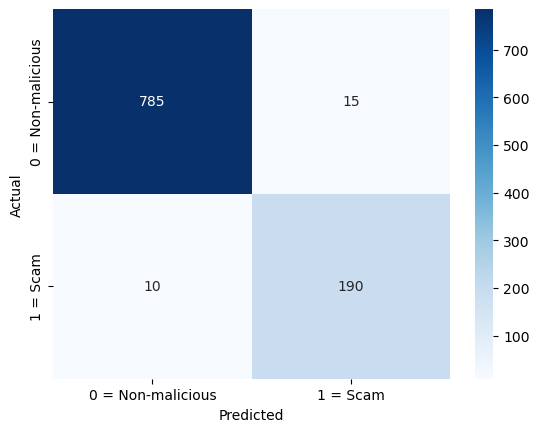

Precision : 92.68%
Recall : 95.00%
Number of OOV words skipped is 179


In [37]:
# Now to plot confusion matrix, show recall and precision
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Use sklearn to get confusion matrix values from predictor
conf_matrix = confusion_matrix(test_df['class'], pred)

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0 = Non-malicious', '1 = Scam'], 
            yticklabels=['0 = Non-malicious', '1 = Scam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

print(f"Precision : {precision_score(test_df['class'], pred) * 100:.2f}%")
print(f"Recall : {recall_score(test_df['class'], pred) * 100:.2f}%")

base_accuracy = accuracy_score(test_df['class'], pred) * 100
base_precision = precision_score(test_df['class'], pred) * 100
base_recall = recall_score(test_df['class'], pred) * 100


# Part 2 Q2

print(f"Number of OOV words skipped is {sum(oov_count.values())}")
# Quite many words were skipped



In [38]:
# Part 2 Q3
from pprint import pprint
# First get predicted class probabilities for each instance
predicted_probs = model.predict_proba(supervised_test)
print(model.classes_)
print(predicted_probs[:10])

instance_probs = []  # First element is instance, second is prob of 0(nonscam), third is prob of 1(scam)
instance_confidence = [] # First element is instance, second is confidence for non-malicious, third for scam, fourth is original text
for i in range(len(predicted_probs)):
    instance = test_df['textPreprocessed'].loc[i]
    instance_probs.append([instance, *(predicted_probs[i].tolist())])
    real_text = test_df['textOriginal'].loc[i]
    
    # index 0 = prob of non scam, 1 = prob of scam, both given the test instance
    non_scam_confidence = predicted_probs[i][0] / predicted_probs[i][1]
    scam_confidence = predicted_probs[i][1] / predicted_probs[i][0]
    
    instance_confidence.append([instance, non_scam_confidence, scam_confidence, real_text])
    

# A : classified scam with high confidence -- element 3
print("Top 5 most confident to be scams as classified by model")
pprint([[f"REAL: {instance[3]}", f"PREP: {instance[0]}"] for instance in sorted(instance_confidence, key=lambda x: x[2], reverse=True)[:5]], compact=False, indent=2)

print("Top 5 most confident to be non-scams as classified by model")
# B : classified non-malicious with high confidence -- element 2
pprint([[f"REAL: {instance[3]}", f"PREP: {instance[0]}"] for instance in sorted(instance_confidence, key=lambda x: x[1], reverse=True)[:5]], compact=False, indent=2)

# C : on the boundary, R near 1.
bound_width = 0.25
print("Boundary instances")
for i in instance_confidence:
    # If R score for scam and nonscam are similar, theyre close to 1
    if abs(i[1] - i[2]) < bound_width:
        print(f"R-non-scam = {i[1]}, R-scam = {i[2]}")
        print(f"REAL: {i[3]}")
        print(f"PREP: {i[0]}")
        print()

[0 1]
[[9.99802906e-01 1.97094426e-04]
 [9.99999405e-01 5.94851453e-07]
 [9.99914145e-01 8.58549033e-05]
 [9.99999967e-01 3.30104973e-08]
 [3.27228433e-08 9.99999967e-01]
 [1.00000000e+00 6.62774452e-14]
 [8.54892539e-01 1.45107461e-01]
 [9.93768132e-01 6.23186845e-03]
 [9.99443233e-01 5.56766595e-04]
 [9.99999933e-01 6.71365781e-08]]
Top 5 most confident to be scams as classified by model
[ [ 'REAL: Urgent -call 09066649731from Landline. Your complimentary 4* Ibiza '
    'Holiday or £10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP '
    '150ppm 18+',
    'PREP: . 4 + call £ - * holiday & urgent 18 t landline 150ppm cash cs '
    'await collection po box sae complimentary 10,000 ibiza'],
  [ 'REAL: Urgent! call 09066612661 from landline. Your complementary 4* '
    'Tenerife Holiday or £10,000 cash await collection SAE T&Cs PO Box 3 WA14 '
    '2PX 150ppm 18+ Sender: Hol Offer',
    'PREP: . 3 4 + ! call : £ offer * holiday & urgent 18 t landline 150ppm '
    'cash cs await co

## 3. Extending the model with semi-supervised training

In [39]:
# Almost exactly the same code as part 2

# Similar to part 1, initialize word matrix BUT dont need to add class labels -- same order
unsup_df = pd.read_csv('COMP30027_2025_asst1_data/sms_unlabelled.csv')

print(unsup_df.shape)
# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
unsup_df = unsup_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
unsup_df.reset_index(drop=True, inplace=True)
# Create a CountVectorizer with the same vocabulary as in part 1
vectorizer = CountVectorizer(vocabulary=words, token_pattern=r'[^\s]+')

# Vectorize data
unsup_data = vectorizer.transform(unsup_df["textPreprocessed"]) 

# Convert to df with columns being the same as the original words trained on
unsup_test = pd.DataFrame.sparse.from_spmatrix(unsup_data, columns=vectorizer.get_feature_names_out())
print(unsup_test.shape)
# Make predictions
unsup_pred = model.predict(unsup_test)

(2000, 3)
(1992, 2006)


In [40]:
# Now that we have the predicted labels, 
 
# Option A : retrain model with ALL of the unsupervised data
# First add the predictions as class labels to the dataframe

unlabelled_df = unsup_test.copy()
unlabelled_df['ScamClassLabel'] = unsup_pred

concat_df = pd.concat([word_df, unlabelled_df], ignore_index=True)

# Now train new model based on this

# Get counts for all features except class label
conc_word_counts = concat_df.drop('ScamClassLabel', axis=1) 

conc_scam_label = concat_df['ScamClassLabel']

concat_model = MultinomialNB() # Uses laplace smoothing with alpha = 1 by default
concat_model.fit(conc_word_counts, conc_scam_label)

MultinomialNB()

97.70%


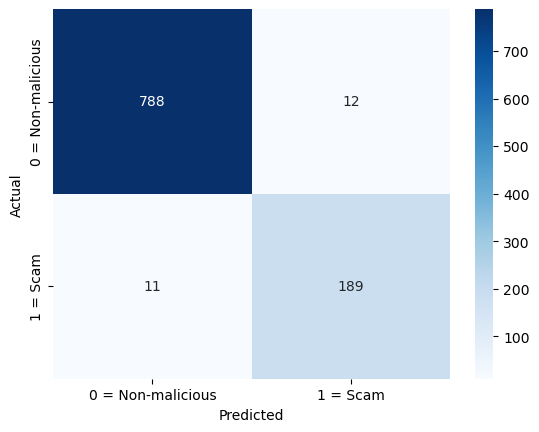

Precision : 94.03%
Recall : 94.50%


In [41]:
# Test performance on supervised dataset
# Make predictions
conc_pred = concat_model.predict(supervised_test)

# Calculate and print accuracy
print(f"{accuracy_score(test_df['class'], conc_pred) * 100:.2f}%")
# Use sklearn to get confusion matrix values from predictor
conf_matrix = confusion_matrix(test_df['class'], conc_pred)

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0 = Non-malicious', '1 = Scam'], 
            yticklabels=['0 = Non-malicious', '1 = Scam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

print(f"Precision : {precision_score(test_df['class'], conc_pred) * 100:.2f}%")
print(f"Recall : {recall_score(test_df['class'], conc_pred) * 100:.2f}%")

In [42]:
import pandas as pd
import numpy as np

unsup_predicted_probs = model.predict_proba(unsup_test)

# Calculate confidence for each instance (non-scam, scam) and store them in a list
unsup_instance_confidence = []

non_scam_confidence = unsup_predicted_probs[:, 0] / unsup_predicted_probs[:, 1]
scam_confidence = unsup_predicted_probs[:, 1] / unsup_predicted_probs[:, 0]

# Combine data into a list
for i in range(len(unsup_predicted_probs)):
    real_text = unsup_df['textOriginal'].iloc[i]
    predicted_class_label = unsup_pred[i]
    unsup_instance_confidence.append([i, non_scam_confidence[i], scam_confidence[i], real_text, predicted_class_label])

# Convert the list to df
unsup_instance_confidence_df = pd.DataFrame(unsup_instance_confidence, columns=['index', 'non_scam_confidence', 'scam_confidence', 'real_text', 'predicted_class_label'])

# Filter based on high conf -- arbitrarily chosen
confidence_boundary = 1000000
highconf_scams = unsup_instance_confidence_df[unsup_instance_confidence_df['scam_confidence'] > confidence_boundary]
highconf_nonscams = unsup_instance_confidence_df[unsup_instance_confidence_df['non_scam_confidence'] > confidence_boundary]

# Sort by conf
highconf_scams_sorted = highconf_scams.sort_values(by='scam_confidence', ascending=False)
highconf_nonscams_sorted = highconf_nonscams.sort_values(by='non_scam_confidence', ascending=False)

# Now get the corresponding rows from the original unlabelled df
highconf_scams_rows = unlabelled_df.loc[highconf_scams_sorted['index']].copy()
highconf_nonscams_rows = unlabelled_df.loc[highconf_nonscams_sorted['index']].copy()

print(highconf_scams_rows.shape)
print(highconf_nonscams_rows.shape)
# Collect high conf instances into df
highconf_df = pd.concat([highconf_scams_rows, highconf_nonscams_rows], ignore_index=True)


(268, 2007)
(426, 2007)


In [43]:
# Now add to model and test for performance
concat_df = pd.concat([word_df, highconf_df], ignore_index=True)

# Now train new model based on this

# Get counts for all features except class label
conc_word_counts = concat_df.drop('ScamClassLabel', axis=1) 

conc_scam_label = concat_df['ScamClassLabel']

concat_model = MultinomialNB() # Uses laplace smoothing with alpha = 1 by default
concat_model.fit(conc_word_counts, conc_scam_label)

MultinomialNB()

97.30%


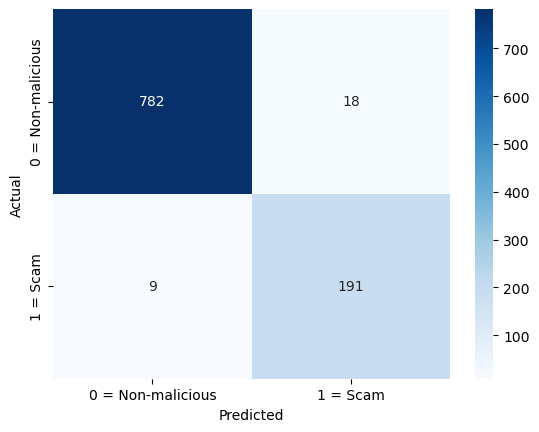

Precision : 91.39%
Recall : 95.50%


In [44]:
# Test performance on supervised dataset
# Make predictions
conc_pred = concat_model.predict(supervised_test)

# Calculate and print accuracy
print(f"{accuracy_score(test_df['class'], conc_pred) * 100:.2f}%")
# Use sklearn to get confusion matrix values from predictor
conf_matrix = confusion_matrix(test_df['class'], conc_pred)

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0 = Non-malicious', '1 = Scam'], 
            yticklabels=['0 = Non-malicious', '1 = Scam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

print(f"Precision : {precision_score(test_df['class'], conc_pred) * 100:.2f}%")
print(f"Recall : {recall_score(test_df['class'], conc_pred) * 100:.2f}%")

In [57]:
# Get predicted probabilities for each instance
unsup_predicted_probs = model.predict_proba(unsup_test)

# Calculate confidence for each instance (non-scam, scam) and store them in a list
unsup_instance_confidence = []

non_scam_confidence = unsup_predicted_probs[:, 0] / unsup_predicted_probs[:, 1]
scam_confidence = unsup_predicted_probs[:, 1] / unsup_predicted_probs[:, 0]

# Combine data into a list
for i in range(len(unsup_predicted_probs)):
    real_text = unsup_df['textOriginal'].iloc[i]
    predicted_class_label = unsup_pred[i]
    unsup_instance_confidence.append([i, non_scam_confidence[i], scam_confidence[i], real_text, predicted_class_label])

# Convert the list to df
unsup_instance_confidence_df = pd.DataFrame(unsup_instance_confidence, columns=['index', 'non_scam_confidence', 'scam_confidence', 'real_text', 'predicted_class_label'])

# Prepare confidence boundaries as logarithmic scale starting from 10^-5 to 10^25
confidence_boundaries = np.logspace(-5, 25, num=30)  # From 10^-5 to 10^25, with 30 points

# Store metrics for different confidence boundaries
accuracies = []
precisions = []
recalls = []

# Instead of making copies for every confidence level, we will directly filter rows in one go
for confidence_boundary in confidence_boundaries:
    # Only filter for rows where confidence is above the boundary, no need for sorting
    highconf_scams = unsup_instance_confidence_df[unsup_instance_confidence_df['scam_confidence'] > confidence_boundary]
    highconf_nonscams = unsup_instance_confidence_df[unsup_instance_confidence_df['non_scam_confidence'] > confidence_boundary]

    # Only get the indices of high-confidence rows from unsup_instance_confidence_df
    highconf_indices = pd.concat([highconf_scams['index'], highconf_nonscams['index']])

    # Get the corresponding rows from the original unlabelled df without multiple concatenations
    highconf_df = unlabelled_df.loc[highconf_indices].copy()

    # Combine the high confidence instances with the original data (word_df)
    concat_df = pd.concat([word_df, highconf_df], ignore_index=True)

    # Prepare the word counts and class labels for training
    conc_word_counts = concat_df.drop('ScamClassLabel', axis=1)
    conc_scam_label = concat_df['ScamClassLabel']

    # Train the model
    concat_model = MultinomialNB()
    concat_model.fit(conc_word_counts, conc_scam_label)

    # Make predictions
    conc_pred = concat_model.predict(supervised_test)

    # Calculate metrics
    accuracies.append(accuracy_score(test_df['class'], conc_pred))
    precisions.append(precision_score(test_df['class'], conc_pred))
    recalls.append(recall_score(test_df['class'], conc_pred))

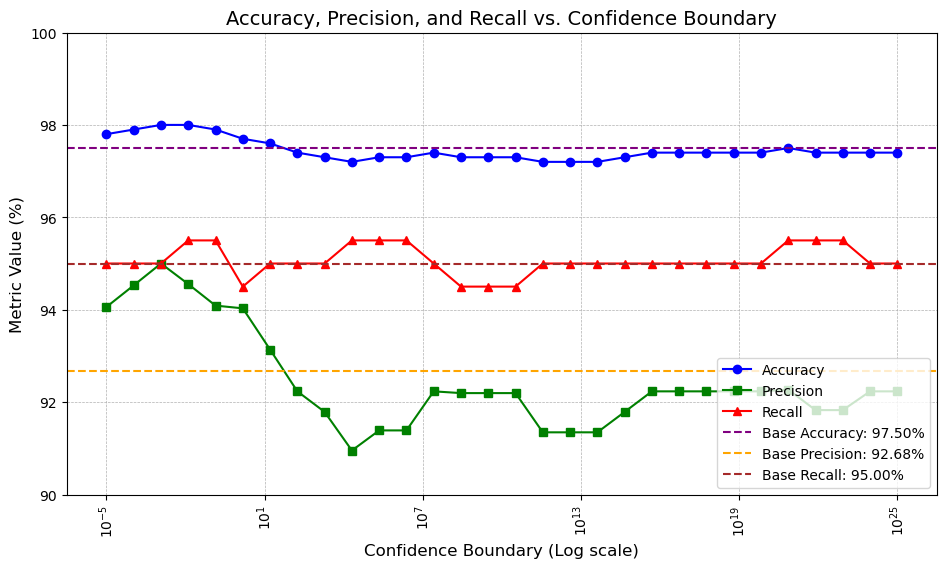

Max Accuracy: 98.00% at confidence boundary 1.2e-03
Max Precision: 95.00% at confidence boundary 1.2e-03
Max Recall: 95.50% at confidence boundary 1.3e-02
[0.978, 0.979, 0.98, 0.98, 0.979, 0.977, 0.976, 0.974, 0.973, 0.972, 0.973, 0.973, 0.974, 0.973, 0.973, 0.973, 0.972, 0.972, 0.972, 0.973, 0.974, 0.974, 0.974, 0.974, 0.974, 0.975, 0.974, 0.974, 0.974, 0.974]


In [60]:
# Plot the results on the same graph
plt.figure(figsize=(12, 6))  # Increased width for better readability

# Plot accuracy
plt.plot(confidence_boundaries, [acc * 100 for acc in accuracies] , label="Accuracy", color='b', marker='o')

# Plot precision
plt.plot(confidence_boundaries, [prec * 100 for prec in precisions], label="Precision", color='g', marker='s')

# Plot recall
plt.plot(confidence_boundaries, [rec * 100 for rec in recalls], label="Recall", color='r', marker='^')

# Add horizontal lines for base values (Accuracy, Precision, Recall)
plt.axhline(base_accuracy, color='purple', linestyle='--', label=f'Base Accuracy: {base_accuracy:.2f}%')
plt.axhline(base_precision, color='orange', linestyle='--', label=f'Base Precision: {base_precision:.2f}%')
plt.axhline(base_recall, color='brown', linestyle='--', label=f'Base Recall: {base_recall:.2f}%')

# Set x-axis to log scale, matching powers of 10
plt.xscale('log')

# Labeling the axes and title
plt.xlabel('Confidence Boundary (Log scale)', fontsize=12)
plt.ylabel('Metric Value (%)', fontsize=12)
plt.title('Accuracy, Precision, and Recall vs. Confidence Boundary', fontsize=14)

# Set y-axis limits to zoom in from 90% to 100%
plt.ylim(90, 100)  # Adjust y-axis to show 90% to 100% only

# Grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format x-axis labels as powers of 10 and rotate them for readability
xticks = np.logspace(np.log10(min(confidence_boundaries)), np.log10(max(confidence_boundaries)), num=6)
plt.xticks(xticks, labels=[f'$10^{{{int(np.log10(x))}}}$' for x in xticks], rotation=90)

# Adjust plot layout for more space on the right side for x-tick labels
plt.subplots_adjust(right=0.85)  # Adjust the right margin to give space to labels

# Move the legend to the bottom left
plt.legend(loc='lower right')

# Save the plot as a PNG file
plt.savefig("combined_metrics_plot.png", dpi=300)

# Show the plot
plt.show()

# Print max values of the metrics and corresponding confidence boundaries
print(f"Max Accuracy: {max(accuracies)*100:.2f}% at confidence boundary {confidence_boundaries[np.argmax(accuracies)]:.1e}")
print(f"Max Precision: {max(precisions)*100:.2f}% at confidence boundary {confidence_boundaries[np.argmax(precisions)]:.1e}")
print(f"Max Recall: {max(recalls)*100:.2f}% at confidence boundary {confidence_boundaries[np.argmax(recalls)]:.1e}")


In [61]:
# Function to calculate metrics 
def get_metrics(concat_model, test_df):
    # Make predictions
    conc_pred = concat_model.predict(supervised_test)

    # Calculate metrics
    accuracy = accuracy_score(test_df['class'], conc_pred)
    precision = precision_score(test_df['class'], conc_pred)
    recall = recall_score(test_df['class'], conc_pred)

    return accuracy, precision, recall

# Initialize data and model
train_df = word_df.copy()
remaining_data = unsup_test.copy()
concat_model = MultinomialNB()

# Get counts for all features except class label
conc_word_counts = word_df.drop('ScamClassLabel', axis=1) 
conc_scam_label = word_df['ScamClassLabel']

# Initial training on the labeled dataset
concat_model.fit(conc_word_counts, conc_scam_label)

# Initialize lists to track metrics
accuracies = []
precisions = []
recalls = []

# Iterative retraining loop
iteration = 0
while not remaining_data.empty:
    iteration += 1
    print(f"Iteration: {iteration}, currently {remaining_data.shape[0]} rows")
    # Step 1: Randomly sample 50% of the remaining unlabelled data
    sampled_data = remaining_data.sample(frac=0.5, random_state=42)
    # Step 7: Remove the sampled data from the remaining data (to ensure no overlap in the next iteration)
    remaining_data = remaining_data.drop(sampled_data.index)
    print(f"Now, remaining data has {remaining_data.shape[0]} rows")
    if sampled_data.shape[0] <= 0:
        break
    
    # Step 2: Predict the labels for the sampled data using the current model
    unsup_pred = concat_model.predict(sampled_data)

    # Step 3: Add the predictions as the class labels to the sampled data
    sampled_data['ScamClassLabel'] = unsup_pred

    # Step 4: Add the labelled sampled data to the training set
    train_df = pd.concat([train_df, sampled_data], ignore_index=True)
    
    # Step 5: Prepare the word counts and class labels for retraining
    conc_word_counts = train_df.drop('ScamClassLabel', axis=1)  # Use the transformed word counts
    conc_scam_label = train_df['ScamClassLabel']

    # Step 6: Retrain the model with the updated training set
    concat_model.fit(conc_word_counts, conc_scam_label)
    
    

    # Step 8: Calculate metrics and append to lists
    accuracy, precision, recall = get_metrics(concat_model, test_df)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)


Iteration: 1, currently 1992 rows
Now, remaining data has 996 rows
Iteration: 2, currently 996 rows
Now, remaining data has 498 rows
Iteration: 3, currently 498 rows
Now, remaining data has 249 rows
Iteration: 4, currently 249 rows
Now, remaining data has 125 rows
Iteration: 5, currently 125 rows
Now, remaining data has 63 rows
Iteration: 6, currently 63 rows
Now, remaining data has 31 rows
Iteration: 7, currently 31 rows
Now, remaining data has 15 rows
Iteration: 8, currently 15 rows
Now, remaining data has 7 rows
Iteration: 9, currently 7 rows
Now, remaining data has 3 rows
Iteration: 10, currently 3 rows
Now, remaining data has 1 rows
Iteration: 11, currently 1 rows
Now, remaining data has 1 rows


In [62]:
print(unsup_test.shape)
print(supervised_test.shape)

(1992, 2006)
(1000, 2006)


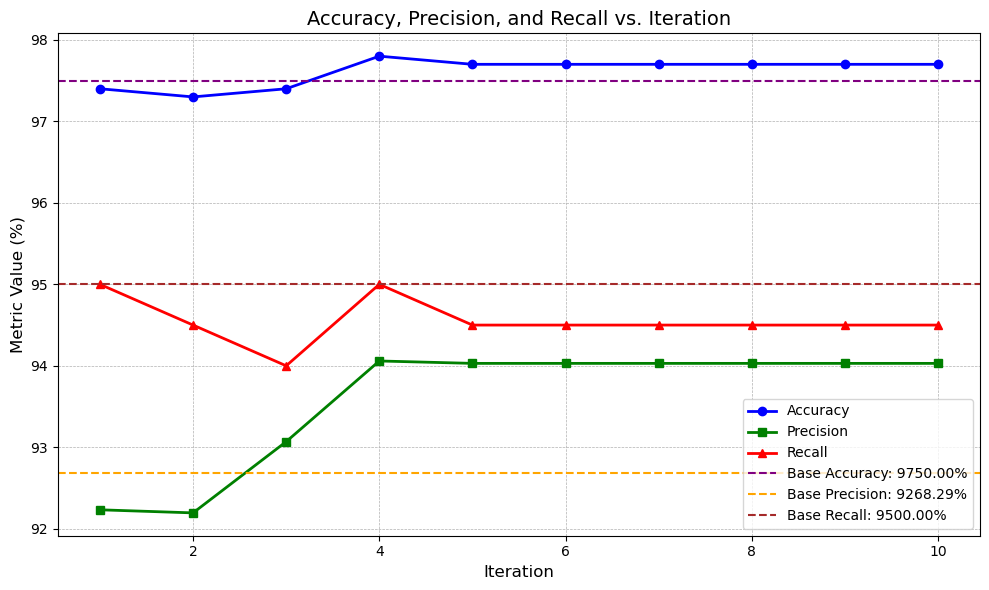

Max Accuracy: 97.80% at iteration 3
Max Recall: 95.00% at iteration 0
Max Precision: 94.06% at iteration 3


In [65]:
plt.figure(figsize=(10, 6))

# Plot accuracy, precision, and recall (multiplying by 100 for percentage representation)
plt.plot(range(1, iteration), [acc * 100 for acc in accuracies], label='Accuracy', color='b', marker='o', linestyle='-', linewidth=2)
plt.plot(range(1, iteration), [prec * 100 for prec in precisions], label='Precision', color='g', marker='s', linestyle='-', linewidth=2)
plt.plot(range(1, iteration), [rec * 100 for rec in recalls], label='Recall', color='r', marker='^', linestyle='-', linewidth=2)

# Add horizontal lines for base values (Accuracy, Precision, Recall) (multiplying by 100 for percentage representation)
plt.axhline(base_accuracy, color='purple', linestyle='--', label=f'Base Accuracy: {base_accuracy:.2f}%')
plt.axhline(base_precision, color='orange', linestyle='--', label=f'Base Precision: {base_precision:.2f}%')
plt.axhline(base_recall, color='brown', linestyle='--', label=f'Base Recall: {base_recall * 100:.2f}%')

# Adding labels and title
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Metric Value (%)', fontsize=12)
plt.title('Accuracy, Precision, and Recall vs. Iteration', fontsize=14)

# Gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend to identify each line
plt.legend(loc='lower right')

# Tight layout to avoid overlap of labels
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("metrics_vs_iteration.png", dpi=300)

# Show the plot
plt.show()

# Print max values of the metrics and corresponding iterations
print(f"Max Accuracy: {max(accuracies) * 100:.2f}% at iteration {np.argmax(accuracies)+1}")
print(f"Max Recall: {max(recalls) * 100:.2f}% at iteration {np.argmax(recalls)+1}")
print(f"Max Precision: {max(precisions) * 100:.2f}% at iteration {np.argmax(precisions)+1}")


In [ ]:
# Above method is definitely wrong, the correct method is:
# Randomly split unlabelled dataset into d1 and d2
# Label d1
# Incorporate d1 into model and retrain
# Label d2, incorporate and retrain
# Test performance metrics on supervised test data -- accuracy, precision, recall = get_metrics(concat_model, test_df)

## 4. Supervised model evaluation